In [13]:
%matplotlib inline


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



In [14]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


In [9]:
categories = None
remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

categories = data_train.target_names    # for case categories == None


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = vectorizer.get_feature_names()


if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
all
data loaded
11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)
20 categories

Extracting features from the training data using a sparse vectorizer
done in 8.393000s at 2.628MB/s
n_samples: 11314, n_features: 129791

Extracting features from the test data using the same vectorizer
done in 4.117000s at 3.352MB/s
n_samples: 7532, n_features: 129791



In [30]:
import pandas as pd
df = pd.DataFrame(columns=['article'], data=data_train.data)
df['target'] = np.array(data_train.target_names)[data_train.target]
df

,article,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,comp.sys.mac.hardware


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 11.504s
test time:  0.093s
accuracy:   0.862
dimensionality: 129791
density: 0.999998

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.82      0.78      0.80       319
           comp.graphics       0.76      0.82      0.79       389
 comp.os.ms-windows.misc       0.79      0.79      0.79       394
comp.sys.ibm.pc.hardware       0.73      0.78      0.76       392
   comp.sys.mac.hardware       0.83      0.86      0.85       385
          comp.windows.x       0.89      0.78      0.83       395
            misc.forsale       0.85      0.91      0.88       390
               rec.autos       0.92      0.92      0.92       396
   

D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scikit_learn-0.18-py2.7-win-amd64.egg\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scikit_learn-0.18-py2.7-win-amd64.egg\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)



accuracy:   0.859
dimensionality: 129791
density: 0.390593

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.82      0.78      0.80       319
           comp.graphics       0.76      0.81      0.79       389
 comp.os.ms-windows.misc       0.78      0.76      0.77       394
comp.sys.ibm.pc.hardware       0.74      0.77      0.75       392
   comp.sys.mac.hardware       0.83      0.86      0.85       385
          comp.windows.x       0.89      0.79      0.83       395
            misc.forsale       0.84      0.90      0.87       390
               rec.autos       0.93      0.90      0.91       396
         rec.motorcycles       0.96      0.96      0.96       398
      rec.sport.baseball       0.91      0.95      0.93       397
        rec.sport.hockey       0.95      0.98      0.97       399
               sci.crypt       0.93      0.95      0.94       396
         sci.electronics       0.82      0.76      0.79  

D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scikit_learn-0.18-py2.7-win-amd64.egg\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scikit_learn-0.18-py2.7-win-amd64.egg\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)



test time:  0.107s
accuracy:   0.843

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.78      0.78       319
           comp.graphics       0.74      0.78      0.76       389
 comp.os.ms-windows.misc       0.79      0.78      0.79       394
comp.sys.ibm.pc.hardware       0.72      0.75      0.74       392
   comp.sys.mac.hardware       0.81      0.83      0.82       385
          comp.windows.x       0.86      0.76      0.81       395
            misc.forsale       0.83      0.89      0.86       390
               rec.autos       0.90      0.90      0.90       396
         rec.motorcycles       0.94      0.94      0.94       398
      rec.sport.baseball       0.93      0.93      0.93       397
        rec.sport.hockey       0.96      0.97      0.96       399
               sci.crypt       0.93      0.93      0.93       396
         sci.electronics       0.78      0.75      0.76       393
             

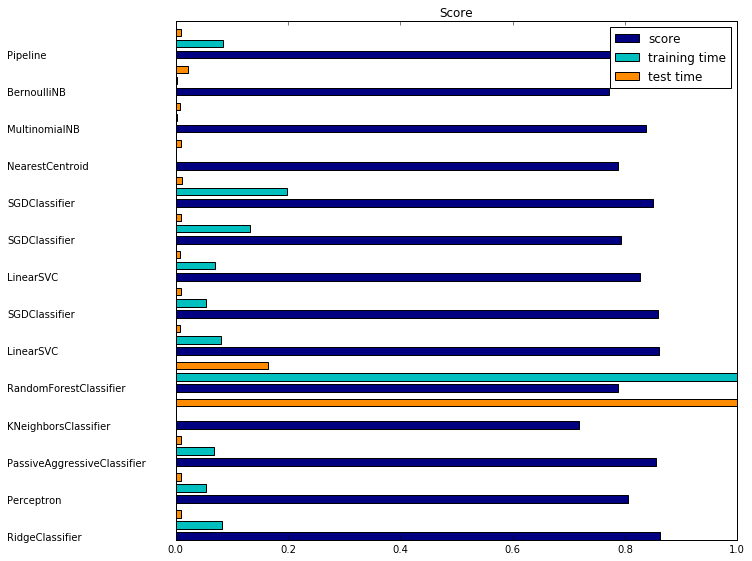

In [16]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
 
    #     if feature_names is not None:
    #         print("top 10 keywords per class:")
    #         for i, category in enumerate(categories):
    #             top10 = np.argsort(clf.coef_[i])[-10:]
    #             print(trim("%s: %s"
    #                   % (category, " ".join(feature_names[top10]))))
    print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                            target_names=categories))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [23]:
Pipeline([
    ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
    ('classification', LinearSVC())
])

Pipeline(steps=[('feature_selection', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)), ('classification', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])